In [1]:
import pandas as pd
test_file_path='~/Downloads/test 2.csv'
test_dataset=pd.read_csv(test_file_path)
# use first 50 rows for dataset
test_dataset = test_dataset.head(50)

In [3]:
from dspy_utils import PersonalizedSummary, Assess
import dspy
summarize = dspy.ChainOfThought(PersonalizedSummary)
assess = dspy.ChainOfThought(Assess)

def test_personalized_summary(df,length=50,style="formal"):
    # empty dictionary to store the results
    results = {}
    documents = []
    summaries = []
    summary_scores = []
    gt_scores = []

    # for each row, get the document and the summary
    for i in range(len(df)):
        document = df.iloc[i]['article']
        summary = summarize(document=document,length=length,style=style,context="").summary

        gt_summary = df.iloc[i]['highlights']
        summary_score = assess(original_document=document,summary=summary, length=length, style=style, context="").score
        gt_score = assess(original_document=document,summary=gt_summary, length=length, style=style, context="").score

        documents.append(document)
        summaries.append(summary)
        summary_scores.append(summary_score)
        gt_scores.append(gt_score)
    
    results['documents'] = documents
    results['summaries'] = summaries
    results['summary_scores'] = summary_scores
    results['gt_scores'] = gt_scores
    return results

# run 3 experiments and get the average score
results = []
for i in range(3):
    results.append(test_personalized_summary(test_dataset))
import numpy as np

def analyze_experiments(results):
    n_experiments = len(results)
    all_summary_scores = [r['summary_scores'] for r in results]
    all_gt_scores = [r['gt_scores'] for r in results]
    
    # Calculate average scores across experiments
    avg_summary_scores = np.mean(all_summary_scores, axis=0)
    avg_gt_scores = np.mean(all_gt_scores, axis=0)
    
    # Calculate standard deviation
    std_summary_scores = np.std(all_summary_scores, axis=0)
    std_gt_scores = np.std(all_gt_scores, axis=0)
    
    # Create summary statistics
    summary_stats = {
        'mean_model_score': np.mean(avg_summary_scores),
        'std_model_score': np.mean(std_summary_scores),
        'mean_gt_score': np.mean(avg_gt_scores),
        'std_gt_score': np.mean(std_gt_scores),
        'model_gt_score_diff': np.mean(avg_summary_scores - avg_gt_scores)
    }
    
    # Create detailed results DataFrame
    detailed_results = pd.DataFrame({
        'documents': results[0]['documents'],  # Use first experiment's documents
        'summaries': results[0]['summaries'],  # Use first experiment's summaries
        'summary_scores': avg_summary_scores,
        'gt_scores': avg_gt_scores
    })
    
    return summary_stats, detailed_results
summary_stats, detailed_results = analyze_experiments(results)

In [4]:
print(summary_stats)

{'mean_model_score': np.float64(8.286666666666667), 'std_model_score': np.float64(0.3060744852959074), 'mean_gt_score': np.float64(7.406666666666667), 'std_gt_score': np.float64(0.33205457119507853), 'model_gt_score_diff': np.float64(0.88)}


In [5]:
result_df=pd.DataFrame(detailed_results)
# save the results to a csv file
result_df.to_csv('~/Downloads/personalized_summary_results_exp1.csv',index=False)

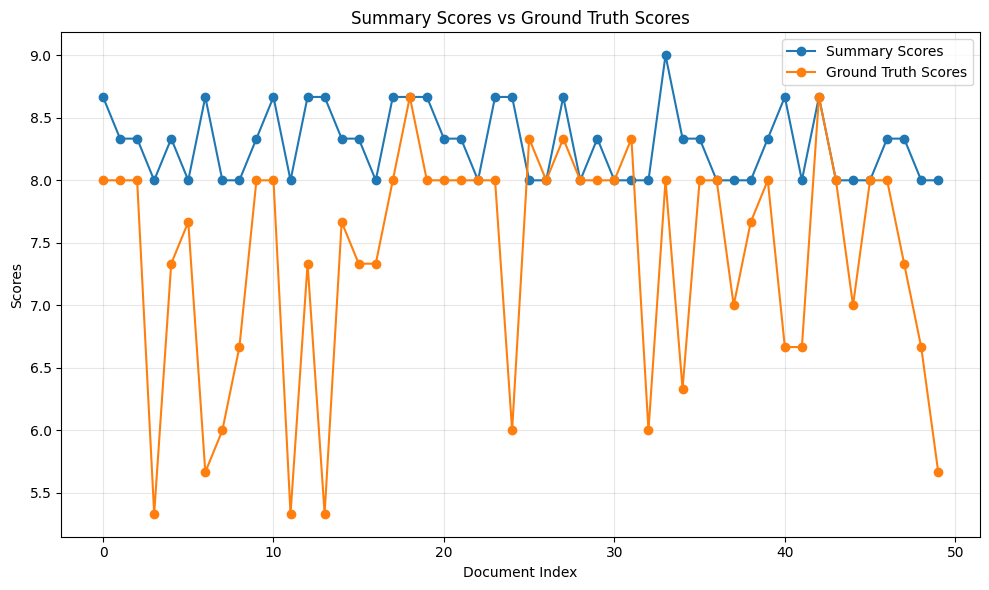

In [6]:
import matplotlib.pyplot as plt
def plot_score_comparison(df):
    """
    Create a simple line plot comparing summary_scores and gt_scores.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'summary_scores' and 'gt_scores' columns
    """
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    
    # Create line plots for both scores
    plt.plot(df['summary_scores'], marker='o', label='Summary Scores')
    plt.plot(df['gt_scores'], marker='o', label='Ground Truth Scores')
    
    # Add labels and title
    plt.xlabel('Document Index')
    plt.ylabel('Scores')
    plt.title('Summary Scores vs Ground Truth Scores')
    
    # Add legend
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
plot_score_comparison(result_df)

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_word_count_comparison(df):
    """
    Create a box plot comparing word counts of summaries and ground truth texts.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'summaries' and 'documents' columns
    """
    # Calculate word counts
    summary_word_counts = df['summaries'].apply(lambda x: len(str(x).split()))
    gt_word_counts = test_dataset['highlights'].apply(lambda x: len(str(x).split()))
    
    # Create data for box plot
    word_counts_data = [summary_word_counts, gt_word_counts]
    
    # Create box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(word_counts_data, labels=['Summaries', 'Ground Truth'])
    
    # Add labels and title
    plt.ylabel('Word Count')
    plt.title('Word Count Distribution: Summaries vs Ground Truth')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show statistics
    print("Summary Statistics:")
    print(f"Summaries - Mean: {summary_word_counts.mean():.1f}, Median: {summary_word_counts.median():.1f}")
    print(f"Ground Truth - Mean: {gt_word_counts.mean():.1f}, Median: {gt_word_counts.median():.1f}")
    
    plt.show()


Summary Statistics:
Summaries - Mean: 50.7, Median: 51.0
Ground Truth - Mean: 50.4, Median: 47.0


/var/folders/cm/_6t_m92546z3p31rmjlfd7v40000gn/T/ipykernel_58131/94217941.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(word_counts_data, labels=['Summaries', 'Ground Truth'])


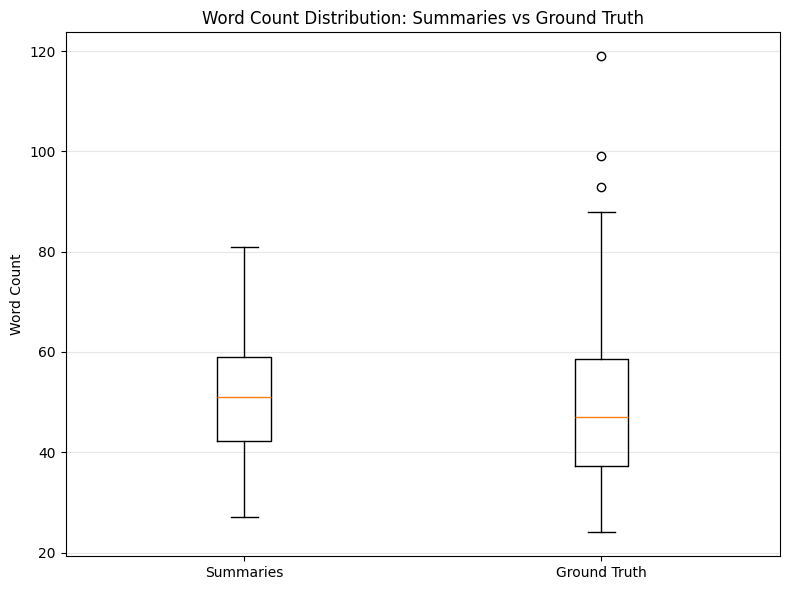

In [9]:
plot_word_count_comparison(result_df)